In [71]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import gridspec
import seaborn as sns
import numpy as np
from sklearn import preprocessing

# Обработка данных

<a id='html_to_csv'></a>
### *html* to *csv*

Скачиваем страницу сайта https://www.notebookcheck-ru.com/Mobilnye-graficheskie-uskoriteli-Tablica.14096.0.html и даём на съедение этому скрипту. (Внимание, не все столбцы!)

Предварительно перевод в ANSI.

In [4]:
with open("all_gpus.html", "r") as myfile:
    data = myfile.read()
myfile.close()

In [5]:
sym_s = 0
count = 0
while sym_s != -1:
    sym_s = data.find('<sup',sym_s+1) # first sup in column
    sym_e = data.find('</sup>',sym_s)
    data = data[:sym_s] + data[sym_e+6:]
    count  = count + 1
print('Обработали записей: ',count)

# print(sym_s)
# print(sym_e)

Обработали записей:  734


Сохраняем результат:

In [6]:
with open("all_gpu_out.html", "w") as myfile:
    myfile.write(data)
myfile.close()

<a id='csv_to_pandas'></a>
### *csv* to *pandas* и предобработка

Предварительно удалил вручную \*, ~ и обязательно заменил `\xa0` на пробел.

In [4]:
data = pd.read_csv('all_gpu_out.csv', keep_default_na=True, na_values='Ранг', decimal='.')

Делаем чистку:
- Пиксельные и вершинные шейдеры это один столбец
- Удаляем SLI-битность из `Шины памяти`, добавляем столбик `SLI`
- Где есть диапазоны - ставим меньший. Субъективно такому железу я не доверяю, где идут переключение частот, глюки, подтормаживания. Добавлю столбец с пометкой.

In [5]:
data.drop_duplicates(subset='Модель', keep='first', inplace=True)

data['Ранг'] = pd.to_numeric(data['Ранг'], errors='coerce')
data = data.drop(data.index[data['Ранг'].isnull()]) # удаляем строки, не содержащие данные

#data.columns[3] # так выяснил что лажа с названиями из-за кодировки, \xa0. А не просто data.columns
data.rename(columns={'Пикс. шейдеры':'П/В шейдеры'}, inplace=True)
data = data.drop('Вершин. шейдеры', axis=1)

non_null = data['Шина памяти'].notnull() 

# SLI
data['SLI'] = 0
contain_2x = data[ non_null ]['Шина памяти'].str.contains('2x')
data1 = data[non_null][contain_2x]
for (index, row) in data1.iterrows():
    data.loc[index, 'SLI'] = 1
    data.loc[index, 'Шина памяти'] = data.loc[index, 'Шина памяти'].replace('2x ','')
del data1 

# pop data from all like xx/xx or xx/xx/xx or yy + xx/xx
data['Шина памяти - Гибрид'] = 0
data1 = data[ non_null ]['Шина памяти'].str.split('\/', expand=True) # будем идти по всем индексам  #contains('\/') 
for (index, row) in data1.iterrows():
    if row[1] != None:
        data.loc[index, 'Шина памяти - Гибрид'] = 1
    if row[0].find(' + ') != -1:
        data.loc[index, 'Шина памяти'] = row[0].split(' + ')[1]
        continue
    data.loc[index, 'Шина памяти'] = row[0]
del data1

for col in ['Штатная частота', 'Turbo', 'Частота памяти']:
    non_null = data[col].notnull() 
    data1 = data[ non_null ][col].str.split('\/', expand=True)#contains('\/')
    for (index, row) in data1.iterrows():
        if row[0].find(' - ') != -1:
            data.loc[index, col] = row[0].split(' - ')[0]
            continue
        data.loc[index, col] = row[0]
del data1

# преобразуем все числовые столбцы в числа
numcols = ['П/В шейдеры',
           'Штатная частота',
           'Turbo',
           'Частота памяти',
           'Шина памяти',
           'Потенциал, %',
           '3DMark Ice Storm GPU',
           '3DMark Cloud Gate GPU',
           '3DMark Fire Strike Graphics',
           '3DMark11 P GPU',
           '3DMark06',
           'GFXBench']
for col in numcols:
    data[col]= pd.to_numeric(data[col], errors='coerce')

data.reindex()
data.to_csv('all_gpu_out_clean.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 1 to 249
Data columns (total 20 columns):
Ранг                           229 non-null float64
Модель                         229 non-null object
Архитектура                    229 non-null object
П/В шейдеры                    229 non-null int64
Штатная частота                199 non-null float64
Turbo                          139 non-null float64
Частота памяти                 147 non-null float64
Шина памяти                    207 non-null float64
Тип                            169 non-null object
Версия DirectX                 229 non-null object
OpenGL                         178 non-null object
Потенциал, %                   207 non-null float64
3DMark Ice Storm GPU           113 non-null float64
3DMark Cloud Gate GPU          200 non-null float64
3DMark Fire Strike Graphics    198 non-null float64
3DMark11 P GPU                 202 non-null float64
3DMark06                       181 non-null float64
GFXBench          

In [6]:
data.head()

,Ранг,Модель,Архитектура,П/В шейдеры,Штатная частота,Turbo,Частота памяти,Шина памяти,Тип,Версия DirectX,OpenGL,"Потенциал, %",3DMark Ice Storm GPU,3DMark Cloud Gate GPU,3DMark Fire Strike Graphics,3DMark11 P GPU,3DMark06,GFXBench,SLI,Шина памяти - Гибрид
1,3.0,NVIDIA GeForce GTX 1080 SLI (Laptop),Pascal,5120,1556.0,1733.0,10000.0,256.0,GDDR5,12 (FL 12_1),4.5,97.9,NaN,161119.0,39221.0,50284.0,NaN,NaN,1,0
2,5.0,NVIDIA GeForce GTX 1070 SLI (Laptop),Pascal,4096,1443.0,1645.0,8000.0,256.0,GDDR5,12 (FL 12_1),4.5,86.2,NaN,152370.0,32969.0,42910.0,NaN,NaN,1,0
3,7.0,NVIDIA GeForce GTX 1080 (Laptop),Pascal,2560,1566.0,1733.0,10000.0,256.0,GDDR5X,12_1,4.5,73.4,420914.0,125447.0,21534.0,28458.0,36927.0,NaN,0,0
4,9.0,NVIDIA GeForce GTX 1080 Max-Q,Pascal,2560,1101.0,1278.0,10000.0,256.0,GDDR5X,12_1,4.5,70.4,387951.0,114542.0,18219.0,23540.0,31555.0,1365.0,0,0
5,10.0,NVIDIA GeForce GTX 980 SLI (Laptop),Maxwell,4096,1126.0,1228.0,3500.0,256.0,GDDR5,12 (FL 12_1),4.5,77.1,NaN,155238.0,25453.0,33169.0,35639.0,NaN,1,0


Найдём GPU, по которым не проводили тесты и их место в рейтинге примерное. **Доверимся людям, которые делали этот рейтинг** и не будем выкидывать такие данные, но анализ будем делать только по имеющим тесты процессорам. А где возможно включим весь список.

In [7]:
# чтобы следующий раз делать анализ без предварительной обработки
if not 'data' in locals():
    data = pd.read_csv('all_gpu_out_clean.csv', keep_default_na=True, na_values='Ранг', decimal='.')
    data.info()

# поиск всех видях с тестами
gpu_list_with_nulls = data[
     data[numcols[6]].isnull() & 
     data[numcols[7]].isnull() & 
     data[numcols[8]].isnull() & 
     data[numcols[9]].isnull() & 
     data[numcols[10]].isnull() & 
     data[numcols[11]].isnull()]

gpu_list_with_tests = data[ ~ data['Ранг'].isin(gpu_list_with_nulls['Ранг'])]
del gpu_list_with_nulls
gpu_list_with_tests.shape

(207, 20)

# Анализ данных

<a id='corr_matrix'></a>
### Матрица корреляций

In [8]:
gpu_list_with_tests['Ранг'] = -gpu_list_with_tests['Ранг']
gpu_list_with_tests = gpu_list_with_tests.fillna(0)

C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


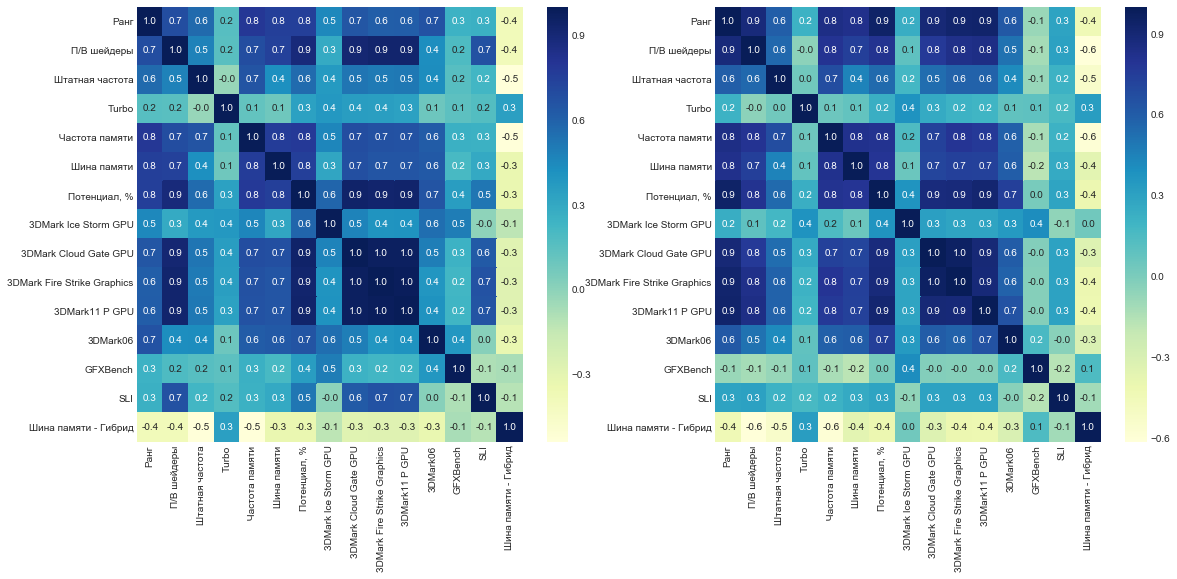

In [376]:
corr = gpu_list_with_tests.corr(method='pearson')
corr_spearman = gpu_list_with_tests.corr(method='spearman')

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(19, 8))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt='.1f', ax=ax[0])
sns.heatmap(corr_spearman, cmap='YlGnBu', annot=True, fmt='.1f', ax=ax[1])
f.savefig('./gfx/gpu_corr_matrix.jpg')

<a id='mean_rate'></a>
### Средний рейтинг

Разные тестирующие системы имеют разные особенности. Например, по `x264` считается реальная задача -- можно оценить  скорость обработки видео. Думаю, что по средней оценке можно судить о рейтенге. Но среднее будем считать только по тем данным которые есть, не учитывая пропуски.

In [9]:
test_col_names = [#'Ранг',
                  '3DMark Ice Storm GPU',
           '3DMark Cloud Gate GPU',
           '3DMark Fire Strike Graphics',
           '3DMark11 P GPU',
           '3DMark06',
           'GFXBench']

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(gpu_list_with_tests[test_col_names[:]])
gpu_list_with_tests_normed = pd.DataFrame(x_scaled, columns=gpu_list_with_tests[test_col_names[:]].columns)
# gpu_list_with_tests_normed['Ранг'] = gpu_list_with_tests[test_col_names[0]]
del x_scaled

Посмотрим, что из себя представляют процессоры.

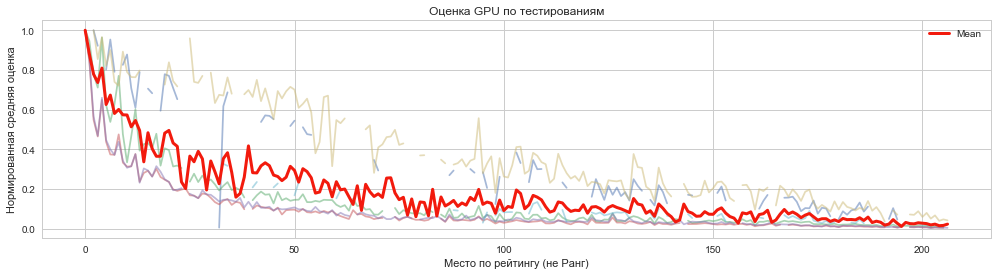

In [95]:
sns.set_style("whitegrid")
mean_gpu_rate = np.mean(gpu_list_with_tests_normed[gpu_list_with_tests_normed>0], 
                        axis=1) # среднее без учёта нулевых значений

plt.figure(figsize=(17,4))
plt.plot(#-gpu_list_with_tests['Ранг'], #[test_col_names[1]], 
         gpu_list_with_tests_normed[gpu_list_with_tests_normed>0], alpha=0.5)
plt.plot(mean_gpu_rate, lw=3, color=(0.95,0.1,0.05), label='Mean')
plt.title('Оценка GPU по тестированиям')
plt.xticks
plt.xlabel('Место по рейтингу (не Ранг)')
plt.ylabel('Нормированная средняя оценка')
plt.legend()
plt.savefig('./gfx/gpu_mean-rate.jpg')

Кто там просаживает в первой сотне? Может где-то лажа?

In [97]:
gpu_list_with_tests.loc[100]

Ранг                                        -185
Модель                         AMD FirePro M5100
Архитектура                                  GCN
П/В шейдеры                                  640
Штатная частота                              725
Turbo                                        775
Частота памяти                              4500
Шина памяти                                  128
Тип                                        GDDR5
Версия DirectX                      12 (FL 11_1)
OpenGL                                       4.3
Потенциал, %                                16.5
3DMark Ice Storm GPU                           0
3DMark Cloud Gate GPU                    16784.5
3DMark Fire Strike Graphics               2327.5
3DMark11 P GPU                              2967
3DMark06                                   18391
GFXBench                                       0
SLI                                            0
Шина памяти - Гибрид                           0
Name: 100, dtype: ob

28    0.351858
29    0.194965
30    0.341010
31    0.286189
dtype: float64


,Ранг,Модель,Архитектура,П/В шейдеры,Штатная частота,Turbo,Частота памяти,Шина памяти,Тип,Версия DirectX,OpenGL,"Потенциал, %",3DMark Ice Storm GPU,3DMark Cloud Gate GPU,3DMark Fire Strike Graphics,3DMark11 P GPU,3DMark06,GFXBench,SLI,Шина памяти - Гибрид
42,-72.0,AMD FirePro W7170M,GCN 3,2048,723.0,0.0,5000.0,256.0,GDDR5,12 (FL 12_0),4.3 / Vulkan,32.7,0.0,43124.0,6935.0,9708.0,28430.0,0.0,0,0
43,-73.0,AMD Radeon R9 M395,GCN,1792,834.0,0.0,5460.0,256.0,GDDR5,12 (FL 12_0),4.3 / Vulkan,19.1,0.0,38490.0,6819.0,8656.0,0.0,0.0,0,0
45,-76.0,NVIDIA GeForce GTX 880M,Kepler,1536,954.0,0.0,5000.0,256.0,GDDR5,12 (FL 11_0),4.3,31.6,268706.0,39891.0,6101.0,8578.0,29036.5,65.0,0,0
46,-81.0,NVIDIA GeForce GTX 780M,Kepler,1536,823.0,0.0,5000.0,256.0,GDDR5,11,4.3,26.6,0.0,35965.0,5244.0,7776.5,23381.5,0.0,0,0


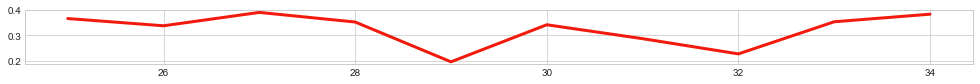

In [391]:
plt.figure(figsize=(17,1))
plt.plot(mean_gpu_rate[25:35], lw=3, color=(0.95,0.1,0.05))
pos = 30
print(mean_gpu_rate[pos-2:pos+2])
gpu_list_with_tests[pos-2:pos+2]

Гипотеза со среднием значением тестов получается не очень сильная из-за пропусков данных, но даёт некоторое представление о том, как падает рейтинг видеокарт.

In [382]:
del gpu_list_with_tests
del gpu_list_with_tests_normed

<a id='cores_and_threads'></a>
### Шина памяти, штатная частота,

In [42]:
sns.set_style('whitegrid')
data.columns

Index(['Ранг', 'Модель', 'Архитектура', 'П/В шейдеры', 'Штатная частота',
       'Turbo', 'Частота памяти', 'Шина памяти', 'Тип', 'Версия DirectX',
       'OpenGL', 'Потенциал, %', '3DMark Ice Storm GPU',
       '3DMark Cloud Gate GPU', '3DMark Fire Strike Graphics',
       '3DMark11 P GPU', '3DMark06', 'GFXBench', 'SLI',
       'Шина памяти - Гибрид'],
      dtype='object')

Посмотрим сравнение по заданному рангу и количеству потоков/ядер.

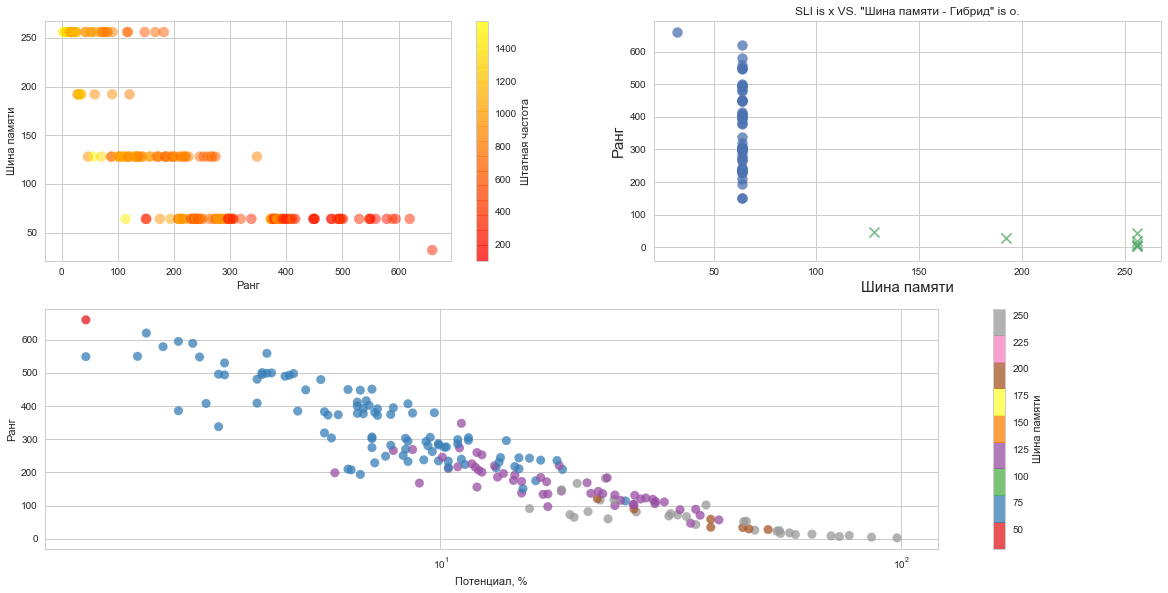

In [98]:
f = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(3, 2)

ax1 = f.add_subplot(gs[0,0])
data.plot.scatter(c='Штатная частота', 
                  y='Шина памяти', 
                  x='Ранг',
                  s=100, 
                  ax=ax1, 
                  alpha=0.5,
                  colormap='autumn', sharex=False)

ax1 = f.add_subplot(gs[0,1])
sc = ax1.scatter(y=data[data['Шина памяти - Гибрид']==1]['Ранг'],
           x=data[data['Шина памяти - Гибрид']==1]['Шина памяти'], 
           s=100, 
           marker='o',
           alpha=0.75,
           cmap='autumn')
ax1.scatter(y=data[data['SLI']==1]['Ранг'],
           x=data[data['SLI']==1]['Шина памяти'], 
           s=100,
           marker='x',
           alpha=0.75,
           cmap='autumn')
ax1.set_ylabel('Ранг', fontsize=15)
ax1.set_xlabel('Шина памяти', fontsize=15)
ax1.set_title('SLI is x VS. "Шина памяти - Гибрид" is o.')

ax1 = f.add_subplot(gs[1,:])
data.plot.scatter(x='Потенциал, %', 
                  c='Шина памяти', 
                  y='Ранг', 
                  s=75, 
                  ax=ax1,  
                  alpha=0.75,
                  colormap='Set1', sharex=False)
ax1.set_xscale('log')

f.savefig('./gfx/gpu_rate_vs_features.jpg')

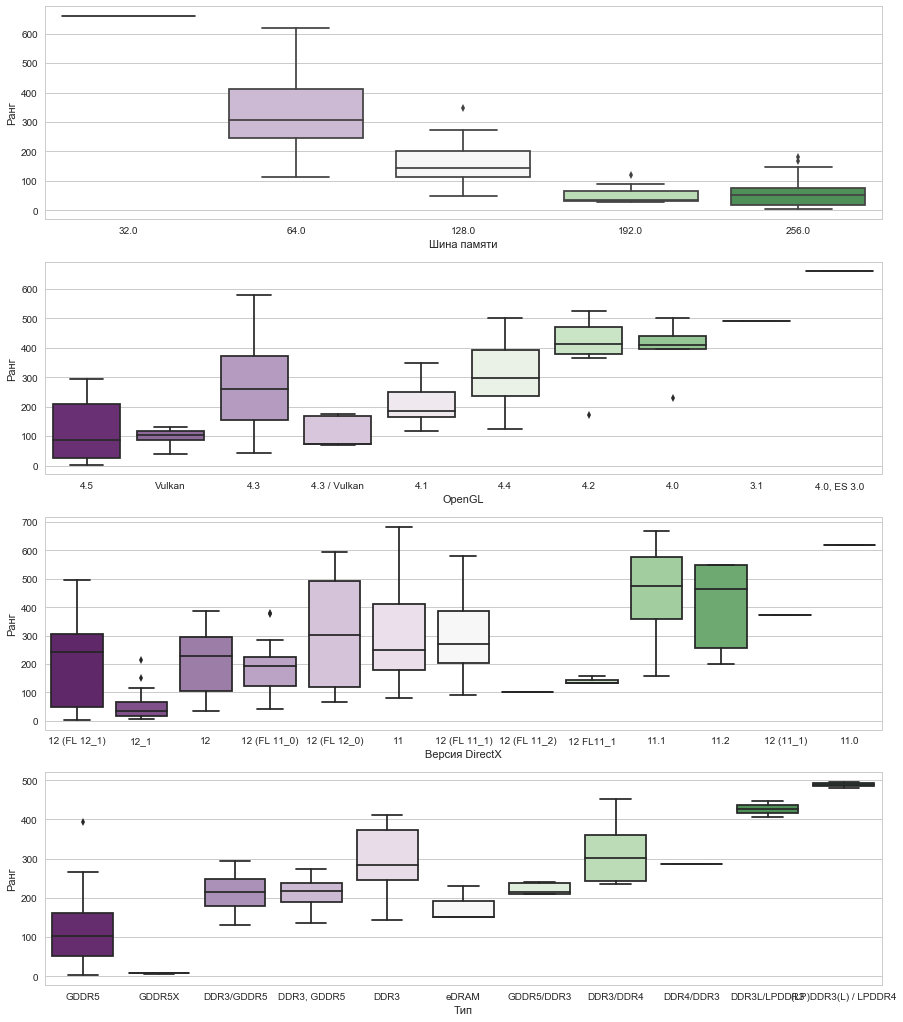

In [89]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 18))
sns.boxplot(y="Ранг", x='Шина памяти', data=data, palette="PRGn", ax=ax[0])
sns.boxplot(y="Ранг", x='OpenGL', data=data, palette="PRGn", ax=ax[1])
sns.boxplot(y="Ранг", x='Версия DirectX', data=data, palette="PRGn", ax=ax[2])
sns.boxplot(y="Ранг", x='Тип', data=data, palette="PRGn", ax=ax[3])

f.savefig('./gfx/gpu_rate_vs_features_1.jpg')